# SHAP Tutorial

Course sections:
1. Standard SHAP values
2. SHAP aggregations
3. Custom SHAP plots
4. SHAP interaction values
5. SHAP for categorical features

<br>**Dataset:** https://archive.ics.uci.edu/ml/datasets/Abalone
<br>https://datahub.io/machine-learning/abalone#resource-abalone


In [88]:
# pip install shap

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

In [90]:
data = pd.read_csv("abalone.csv")

data.columns = ['sex', 'length', 'diameter', 
                                         'height', 'whole_weight', 'shucked_weight',
                                         'viscera_weight', 'shell_weight', 'rings']
print(len(data))
data.head()

4177


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


''

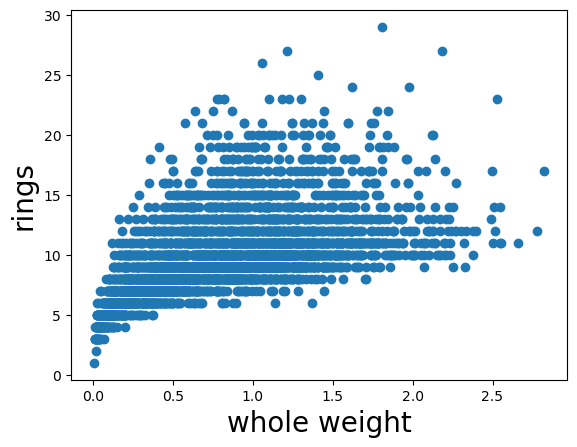

In [91]:
plt.scatter(data['whole_weight'], data['rings'])
plt.ylabel('rings', size=20)
plt.xlabel('whole weight', size=20)
;

''

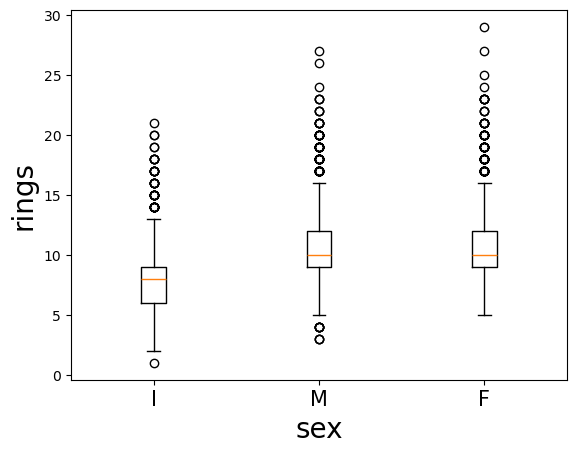

In [92]:
plt.boxplot(data[data.sex=='I']['rings'],positions=[1])
plt.boxplot(data[data.sex=='M']['rings'],positions=[2])
plt.boxplot(data[data.sex=='F']['rings'],positions=[3])

plt.xticks(ticks=[1,2,3], labels=['I','M','F'], size=15)
plt.ylabel('rings', size=20)
plt.xlabel('sex', size=20)
;

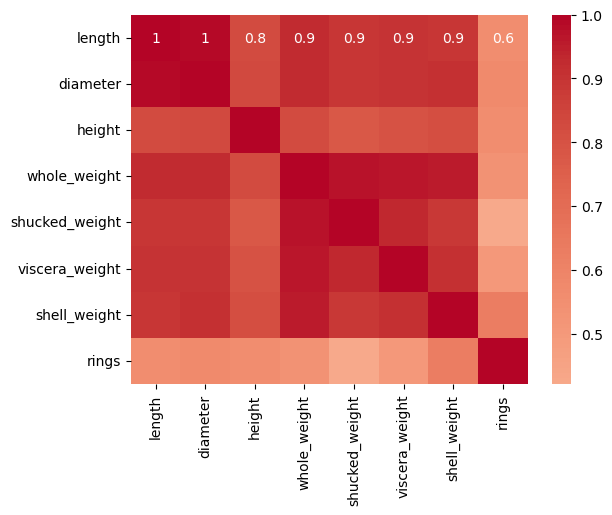

In [93]:
cont = ['length', 'diameter', 
     'height', 'whole_weight', 'shucked_weight',
     'viscera_weight', 'shell_weight', 'rings']
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()

sns.heatmap(corr_matrix,
           cmap='coolwarm',
           center=0,
           annot=True,
           fmt='.1g');

## Feature Engineering

In [94]:
data.columns

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')

In [95]:
# dropping 'diameter' and 'whole_weight' since it's highly correlated features
y = data['rings'].copy()
X = data[['sex','length',
     'height',  'shucked_weight',
     'viscera_weight', 'shell_weight']].copy()

In [96]:
# Create dummy variables and dropping categorical features
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()

,length,height,shucked_weight,viscera_weight,shell_weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


## Modelling

In [97]:
# Train model
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

''

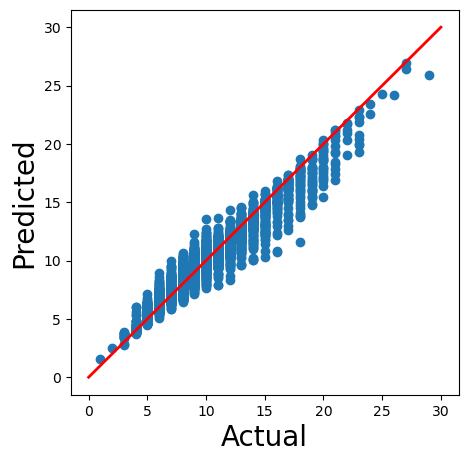

In [98]:
# Get prediction
y_pred = model.predict(X)

# Model evaluation
plt.figure(figsize=(5,5))

plt.scatter(y,y_pred)
plt.plot([0,30],
        [0,30],
        color='r',
        linestyle='-',
        linewidth=2)

plt.ylabel('Predicted', size=20)
plt.xlabel('Actual', size=20)
;

## 1) Standard SHAP values

In [99]:
# Get shap values

explainer= shap.Explainer(model)
shap_values = explainer(X)

# if you have a large feature matrix this step could take long time to run,
# in this case you can pass just subset

# shap_values = explainer(X[0:100])

In [100]:
np.shape(shap_values.values)

(4177, 8)

### Waterfall plot

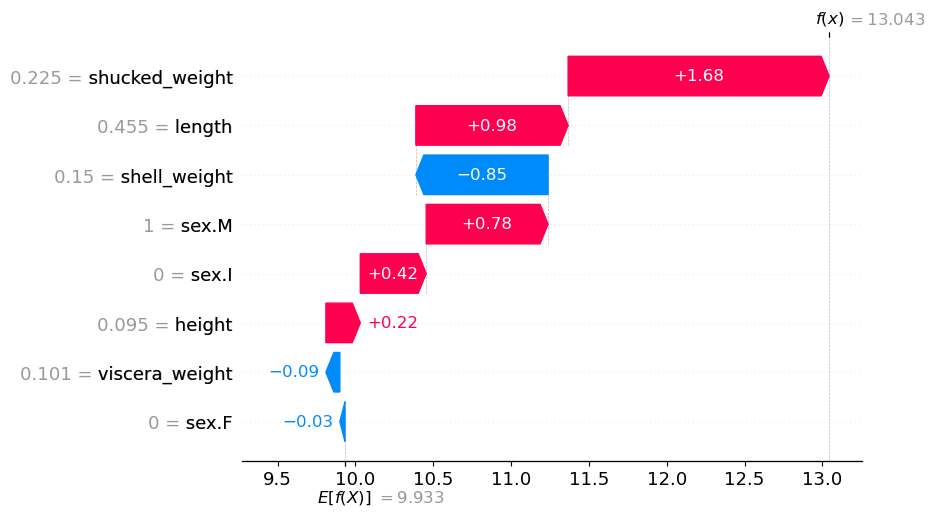

In [101]:
# Waterfall plot for first (!!!) obesrvation

# f(x) is predicted number of rings of this particular abalon
# E[f(X)] average prediction, just simple average of rings (mean of y) 

# in this example shucked_weight increased the predicted value of rings by 1.68
# on the left we see the actual features value for the first observation
 
shap.plots.waterfall(shap_values[0])

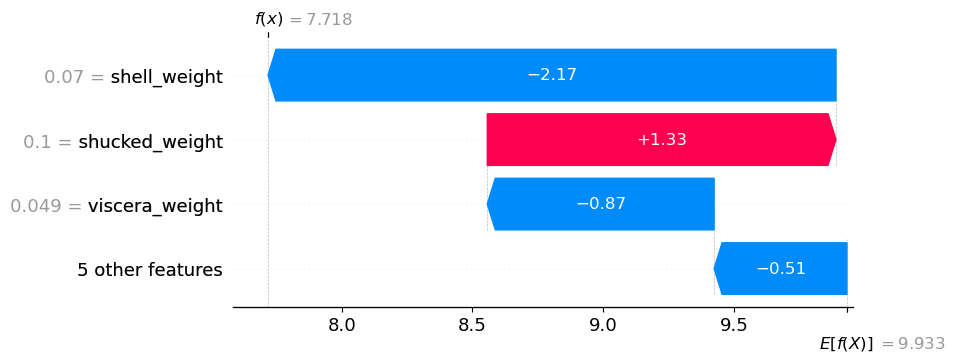

In [102]:
# Waterfall plot for first observation

# liimt the chart to 4 most significant features
shap.plots.waterfall(shap_values[1], max_display=4)

### Force plot

In [103]:
# we see how each feature contributed to encrease, decrease first observation prediction over the mean
shap.plots.force(shap_values[0])

### Stacked force plot

In [104]:
shap.plots.force(shap_values[0:100])
# the plot is interactive 
# whe can filter by feature 
# and we can see how the feature effects the prediction
# for example, if we chose shell weight we will the that when the shell weight increases shape values also increases, in other worlds all the abalons tend to have hevier shells

### Absolute Mean SHAP

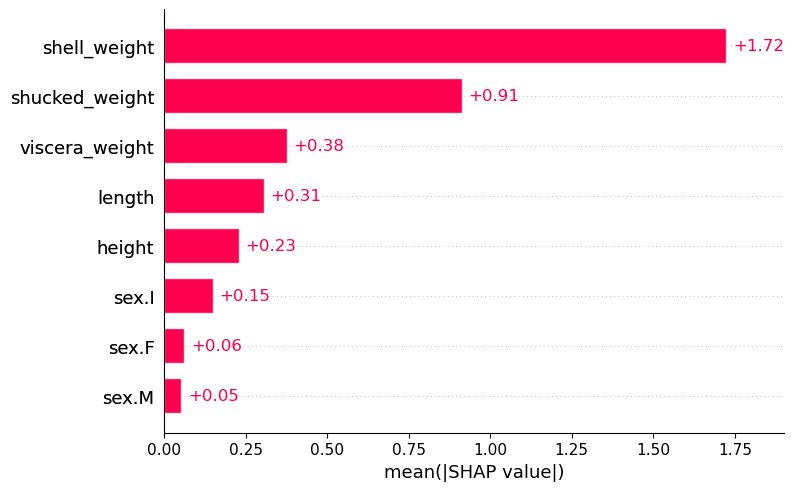

In [105]:
shap.plots.bar(shap_values)
# provides the absolute mean shap value
# indicates the contribution of each feature to prediction
# here all the values are absolute, thus positive, actual shap for each feature can be negative or positive
# but here we calculate mean of abs shap values of each feature

### Beeswarm plot

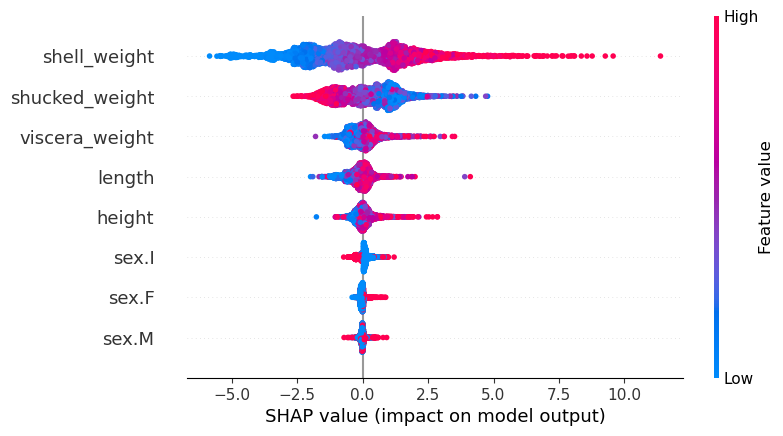

In [106]:
shap.plots.beeswarm(shap_values)
# blue indicates low shap values and red indicates high shap values
# here on the shell weight feature we can see when when the value of the feature increases the shap value also increases
# on the other side we see that shucked weight reletion is the opposite, when the shucked weight increases the shap value decreases

### Heatmap

In [ ]:
shap.plots.heatmap(shap_values)

### Dependence plots

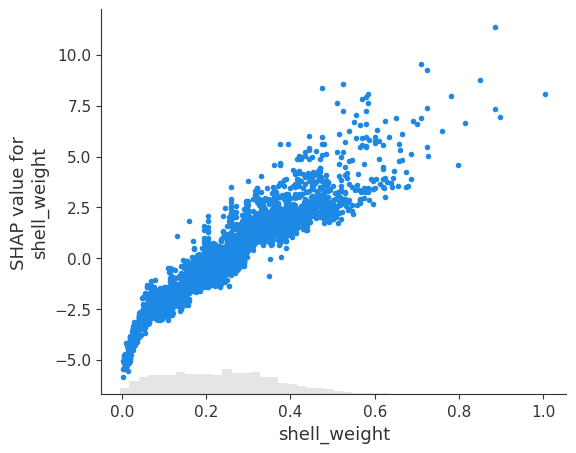

In [20]:
# Particulary useful when there is no linear relationship with the target variable
# We can see on the next example that the relationship not perfectly linear
shap.plots.scatter(shap_values[:,"shell_weight"])

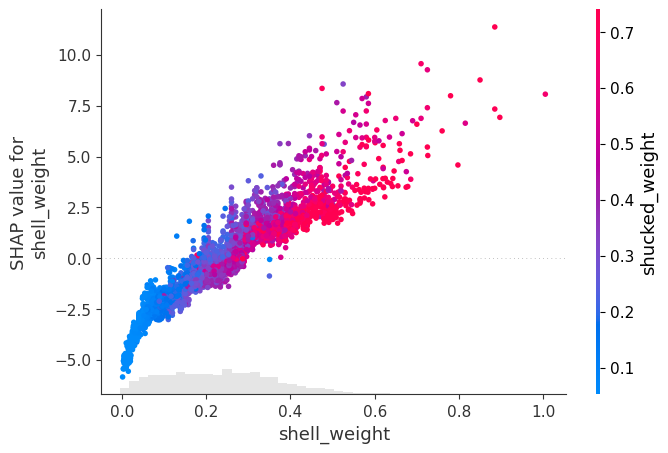

In [21]:
# adding color map for additional feature shucked weight 
# we can see when the shell weight large the shucked weight also large, indecates the correlation between the two features
# shape values are large when both shell weight and shucked weight are large

shap.plots.scatter(shap_values[:,"shell_weight"],
                  color=shap_values[:,"shucked_weight"])

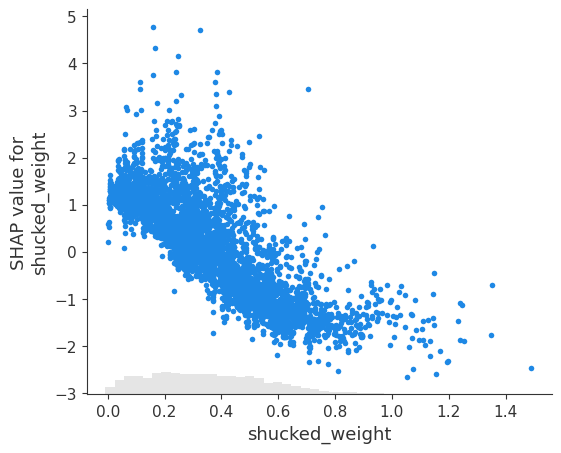

In [22]:
# as we sought on the Beeswarm plot as the shucked weight increases the shap value decreases
shap.plots.scatter(shap_values[:,"shucked_weight"])

## Mathematics behind Shapley Values

<pre>
<b>Shapley value</b> = expected marginal contribution
              = weighted average of a player's contributions 
Shapley values are a fair way to divide a games value amongst it's players.


<img src ="images//img001.jpg">


C123 - gain of 3 players coalition
C12 - gain of coalition of player 1 and 2
etc ...

Calculation of marginal contribution of player one
We'll calculate all the combinations in which the player 1 can join a coalition and it's average

<img src ="images//img002.jpg">
</pre>

In [23]:
shapley_value_player1 = 5000*(1/3) + 2500*(1/6) + 7500*(1/6) + 5000*(1/3)
shapley_value_player1

5000.0

<pre>
The weights are probabilities of the combinations explained:

There are 6 possibilities to combine all 3 players. 
3!
</pre>

In [24]:
from math import factorial
factorial(3)

6

<pre>
when other 2 players join player 1 there are only 2 out of 6 combinations possible:
123
132
2/6 = 1/3
</pre>

In [25]:
round(2/factorial(3),2)

0.33

<pre>
When just one of two others players join the first player, there are 1 out of 6 combinations possible
12
13
1/3! = 6
</pre>

In [26]:
round(1/factorial(3),3)

0.167

<pre>
same way it's 2 out of 6 combinations possible to player 1 not to join any of others players:
1 - 23
1 - 32
2/6 = 1/3
</pre>

In [27]:
round(2/factorial(3),2)

0.33

<pre>
p! =  number of ways to form a coalition of p players
|S| =  number of players in the coalition S
|S|! = number of ways coalition S can form
(p-|S|-1)! = number of ways players can join after player i joins
[val(S U {i}) - val(S)] -  value of the coalition including player i less the value excluding player i,
                           in other words the marginal contribution of player i to coalition S
<img src ="images//img003.jpg">
</pre>

## Shapley values in Machine Learning

<pre>
In Machine Learning our prize is our prediction and our players are our features:
S - coalition of feature values
f - model prediction
p - number of features in the model

Because of computational cost SHAP module takes samples not all data and features

Approximation methods:

KernelSHAP  - reframes the shapley values as a parameters of linear model
TreeSHAP - (only can be used in tree based algorithms)faster that KernelSHAP takes advantage of stuctures of 
individual trees in ensembler models
</pre>

## Limitations of SHAP

<pre>
<b>Limitation 1 SHAP package:</b>
Works best with most popular packages, such as scikit-learn, xgboost
Less with less common packages

<b>Limitation 2 Feature dependencies:</b>
If feature dependend of each other (multicoulinearity/interdependency)
For example in KernelSHAP uses linear regression coefs, and basic assumption is that features are independent, which is not always true.
But when features are correlated it's can lead to unrealistic predictions and shapley values
Also regression based on correlations not on associations (like cancer propability by country of origin (skin color))

<b>Limitation 3 Causal Inference:</b>
Shap indicated how the feature important to the prediction not to the target value
SHAP indicates how the feature important to the model not a measure of how important a feature in the real world
Model not nesseserily a good representation of the reality
For example using proxy variables, not extending beyond the model

<b>Limitation 3 Human Error:</b>
Wrong interpritations of shapley value by human

<b>Bottom line</b>
Should be taken with scepcetism and given to additional alalysis and consideration
</pre> 

## SHAP for Binary Variables

In [29]:
# binary target variable
y_bin = [1 if y_ > 10  else 0 for y_ in y]

In [31]:
# train model
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X,y_bin)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [32]:
# get shap values

explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X)

print(shap_values_bin.shape)

(4177, 8)


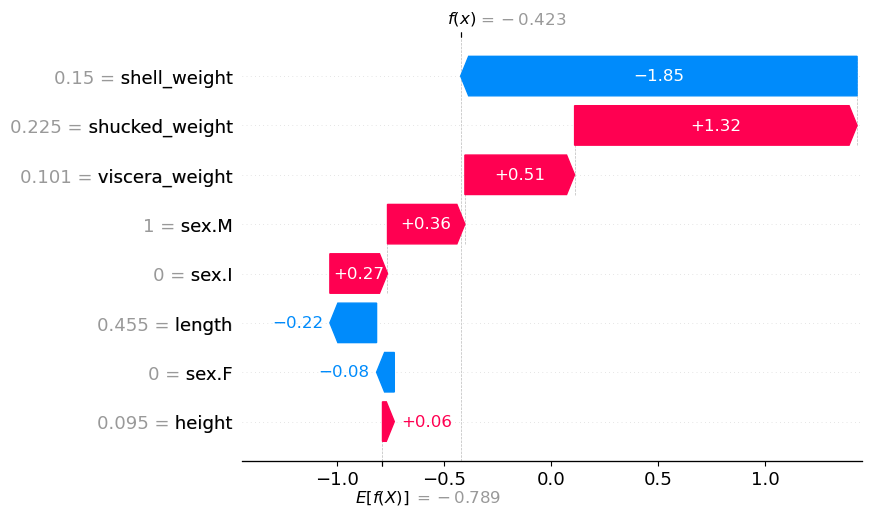

In [48]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values_bin[0])

In [66]:
model_bin.predict_proba(X)[0][1]

0.39573342

<br>The difference with plot of continious values is that here the base value is -0.789 which is average predicted log odds
<br>For this specific observation the predicted probability P was 0.3958$$f(x) = \ln\left(\frac{P}{1-P}\right) = \ln\left(\frac{0.3958}{1-0.3958}\right) = -0.423$$



In [46]:
# force plot for first observation
shap.plots.force((shap_values_bin[0]), link="logit")

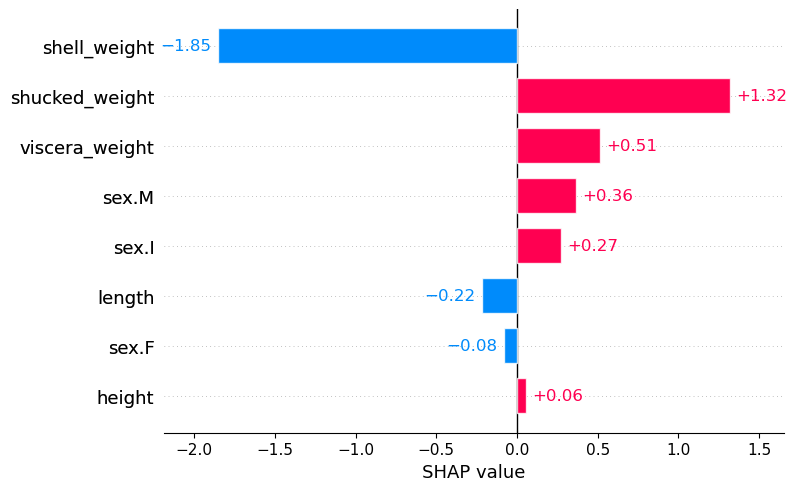

In [49]:
# bar plot for first observation
shap.plots.bar(shap_values_bin[0])

## Multiclass categorical target variables

In [67]:
# categorical target variable
y_cat = [2 if y_ > 12 else 1 if y_ > 8 else 0 for y_ in y]

In [68]:
# train model
model_cat = xgb.XGBClassifier(objective="binary:logistic")
model_cat.fit(X, y_cat)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [69]:
# get probability predictions
model_cat.predict_proba(X)[0]

array([0.30308628, 0.21332613, 0.48358762], dtype=float32)

In [71]:
# get shap values
explainer = shap.Explainer(model_cat)
shap_values_cat = explainer(X)

print(np.shape(shap_values_cat))

(4177, 8, 3)


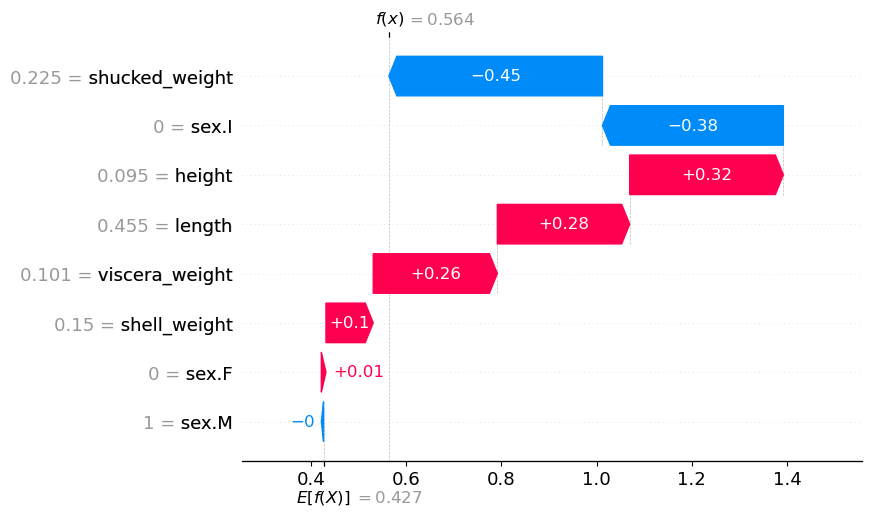

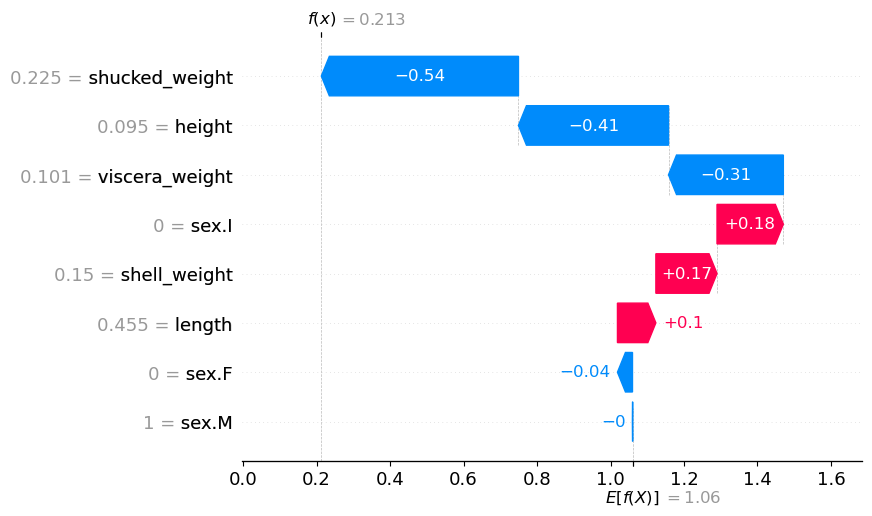

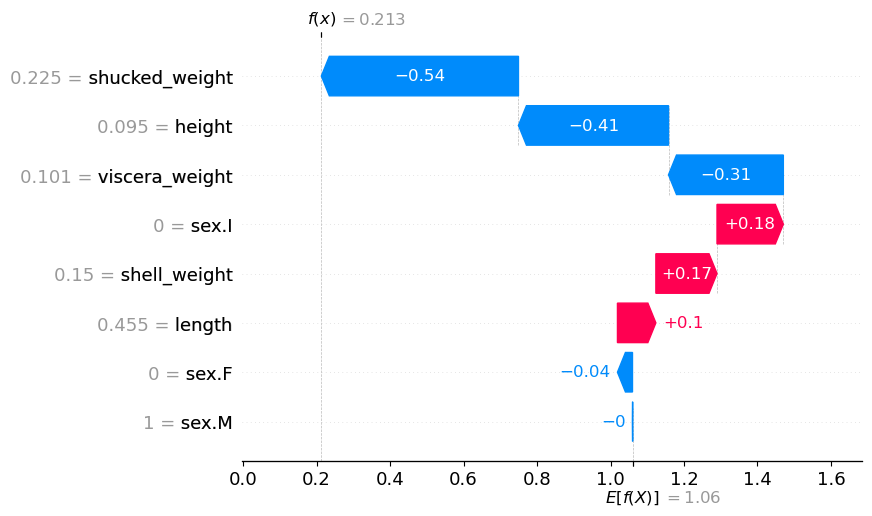

In [74]:
# Showing shape values for each category

# waterfall plot for first observation
# first category
shap.plots.waterfall(shap_values_cat[0, :, 0])
# second category
shap.plots.waterfall(shap_values_cat[0, :, 1])
# third category
shap.plots.waterfall(shap_values_cat[0, :, 1])

In [76]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x/ e_x.sum(axis=0)
    
# convert softmax to probability
x = [0.383, -0.106, 1.211]
softmax(x) # showes predicted probabilities

array([0.25628041, 0.15716122, 0.58655837])

### Aggregation multiclass SHAP values

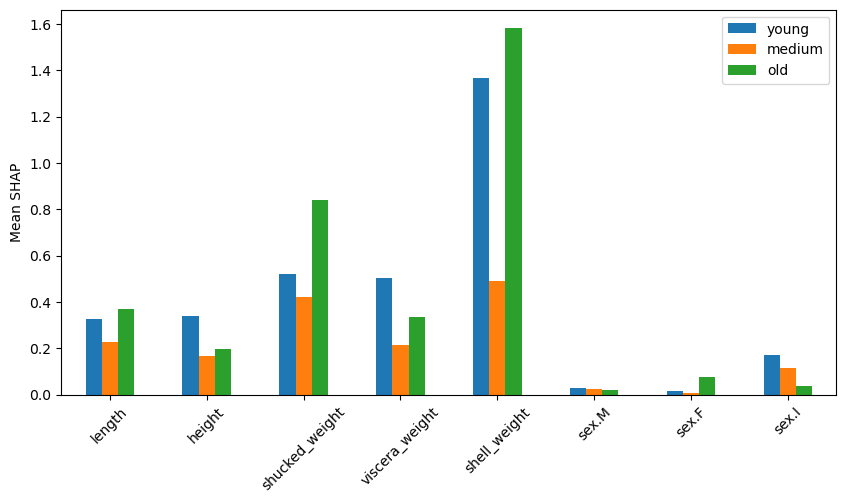

In [83]:
# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_cat.values[:,:,0]), axis=0)
mean_1 = np.mean(np.abs(shap_values_cat.values[:,:,1]), axis=0)
mean_2 = np.mean(np.abs(shap_values_cat.values[:,:,2]), axis=0)

df = pd.DataFrame({"young":mean_0, "medium":mean_1,"old":mean_2})

# plot mean SHAP values
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.plot.bar(ax=ax)
ax.set_ylabel("Mean SHAP", size=10)
ax.set_xticklabels(X.columns, rotation=45, size=10)
ax.legend(fontsize=10)
plt.show()

### Showing SHAP values for only the predicted class

In [84]:
# get model predictions
preds = model_cat.predict(X)

new_shap_values = []
for i, pred in enumerate(preds):
    # get shap values for predicted class
    new_shap_values.append(shap_values_cat.values[i][:,pred])

# replace shap values
shap_values_cat.values = np.array(new_shap_values)
print(shap_values_cat.shape)

(4177, 8)


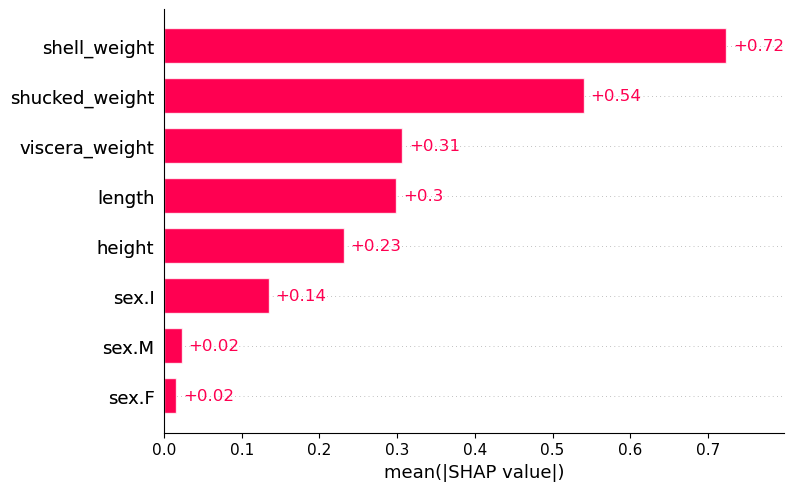

In [86]:
shap.plots.bar(shap_values_cat)

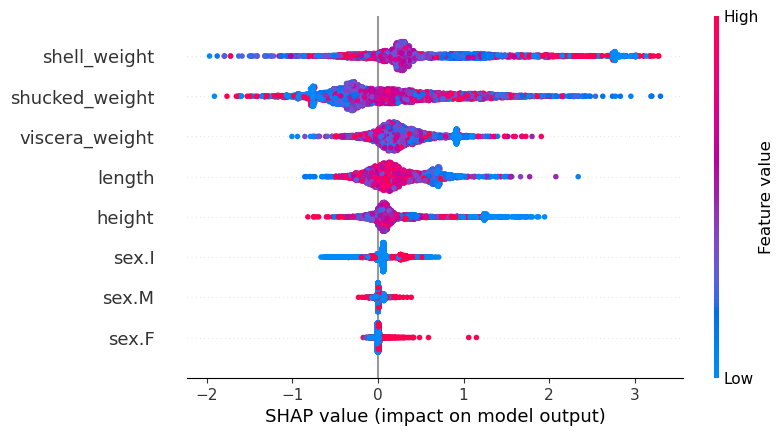

In [87]:
# we don't see clear relationship between shapley values and features values 
# it's because the features have different relationships depending on the predicted class
shap.plots.beeswarm(shap_values_cat)